In [1]:
import context
from numlabs.lab5.lab5_funs import Integrator
from collections import namedtuple
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

******************************
context imported. Front of path:
/Users/zuni/repos/numeric_2024
back of path: /Users/zuni/miniconda3/envs/numeric_2024/lib/python3.12/site-packages
******************************

through /Users/zuni/repos/numeric_2024/notebooks/lab5/context.py


# Problem Initial

In [2]:
class Integ54(Integrator):
    def set_yinit(self):
        #
        # read in 'albedo_white chi S0 L albedo_black R albedo_ground'
        #
        uservars = namedtuple('uservars', self.config['uservars'].keys())
        self.uservars = uservars(**self.config['uservars'])
        #
        # read in 'whiteconc blackconc'
        #
        initvars = namedtuple('initvars', self.config['initvars'].keys())
        self.initvars = initvars(**self.config['initvars'])
        self.yinit = np.array(
            [self.initvars.whiteconc, self.initvars.blackconc])
        self.nvars = len(self.yinit)
        return None

    def __init__(self, coeff_file_name):
        super().__init__(coeff_file_name)
        self.set_yinit()

    def find_temp(self, yvals):
        """
            Calculate the temperatures over the white and black daisies
            and the planetary equilibrium temperature given the daisy fractions

            input:  yvals -- array of dimension [2] with the white [0] and black [1]
                    daisy fractiion
            output:  white temperature (K), black temperature (K), equilibrium temperature (K)
        """
        sigma = 5.67e-8  # Stefan Boltzman constant W/m^2/K^4
        user = self.uservars
        bare = 1.0 - yvals[0] - yvals[1]
        albedo_p = bare * user.albedo_ground + \
            yvals[0] * user.albedo_white + yvals[1] * user.albedo_black
        Te_4 = user.S0 / 4.0 * user.L * (1.0 - albedo_p) / sigma
        temp_e = Te_4**0.25
        eta = user.R * user.L * user.S0 / (4.0 * sigma)
        temp_b = (eta * (albedo_p - user.albedo_black) + Te_4)**0.25
        temp_w = (eta * (albedo_p - user.albedo_white) + Te_4)**0.25
        return temp_w, temp_b, temp_e

    def derivs5(self, y, t):
        """y[0]=fraction white daisies
           y[1]=fraction black daisies
           y[2]=fraction of rabbits if using rabbits.yaml
           no feedback between daisies and
           albedo_p (set to ground albedo)
        """
        temp_w, temp_b, temp_e = self.find_temp(y)

        if (temp_b >= 277.5 and temp_b <= 312.5):
            beta_b = 1.0 - 0.003265 * (295.0 - temp_b)**2.0
        else:
            beta_b = 0.0

        if (temp_w >= 277.5 and temp_w <= 312.5):
            beta_w = 1.0 - 0.003265 * (295.0 - temp_w)**2.0
        else:
            beta_w = 0.0
        user = self.uservars
        bare = 1.0 - y[0] - y[1]
        # create a 1 x 2 element vector to hold the derivitive
        f = np.empty_like(y)
        f[0] = y[0] * (beta_w * bare - user.chi)
        f[1] = y[1] * (beta_b * bare - user.chi)
        return f

In [4]:
# higher black daisy fraction
theSolver1 = Integ54('initial1.yaml')
timevals1, yvals1, errorlis1t = theSolver1.timeloop5fixed()
daisies1 = pd.DataFrame(yvals1, columns=['white', 'black'])

temp_w1 = []
temp_b1 = []
temp_e1 = []
for i in range(len(timevals1)):
    w1,b1,e1 = theSolver1.find_temp(yvals1[i,:])
    temp_w1.append(w1- 273.15)
    temp_b1.append(b1- 273.15)
    temp_e1.append(e1- 273.15)

In [5]:
# 0 black daisy fraction
import matplotlib.pyplot as plt
import pandas as pd

theSolver = Integ54('initial.yaml')
timevals, yvals, errorlist = theSolver.timeloop5fixed()
daisies = pd.DataFrame(yvals, columns=['white', 'black'])

temp_w = []
temp_b = []
temp_e = []
for i in range(len(timevals)):
    w,b,e = theSolver.find_temp(yvals[i,:])
    temp_w.append(w- 273.15)
    temp_b.append(b- 273.15)
    temp_e.append(e- 273.15)

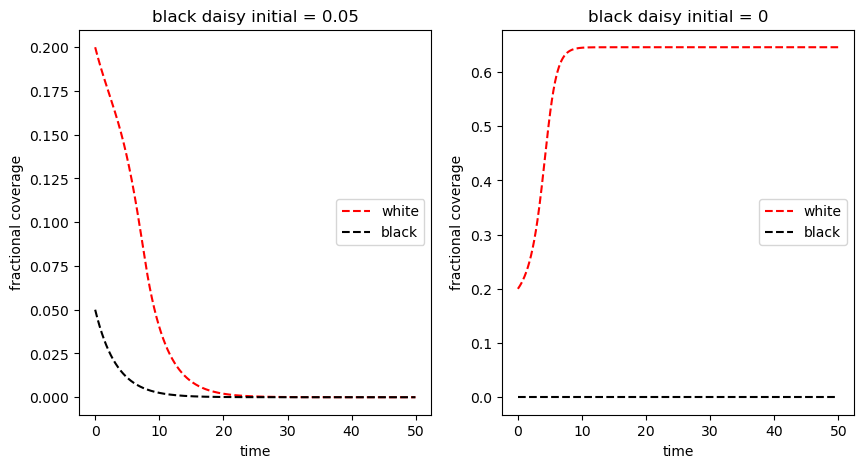

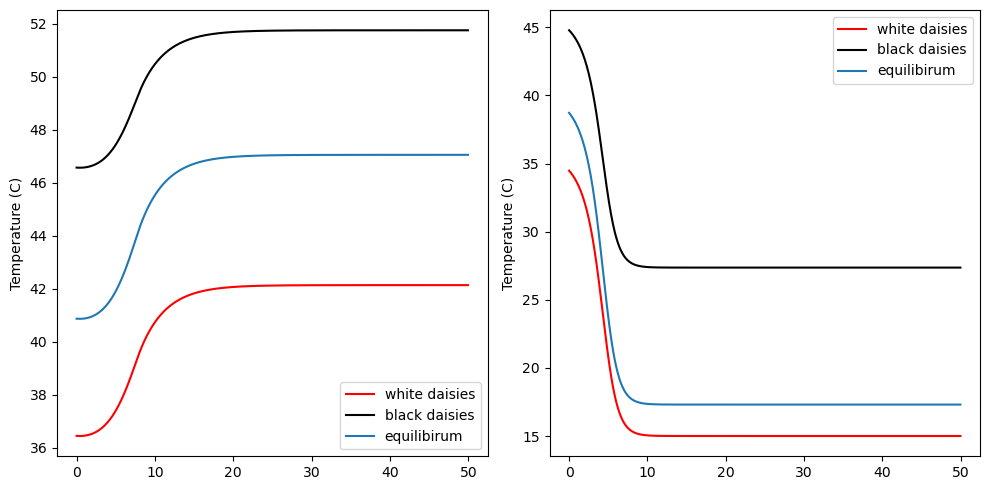

In [18]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.plot(timevals1,daisies1['white'],linestyle='--', color='r', label='white')
ax1.plot(timevals1, daisies1['black'],linestyle='--', color='k', label='black')
ax1.set_title('black daisy initial = 0.05')
ax1.set_xlabel('time')
ax1.set_ylabel('fractional coverage')
ax1.legend(loc='center right')

ax2.plot(timevals, daisies['white'],linestyle='--', color='r', label='white')
ax2.plot(timevals, daisies['black'],linestyle='--', color='k', label='black')
ax2.set_title('black daisy initial = 0')
ax2.set_xlabel('time')
ax2.set_ylabel('fractional coverage')
ax2.legend(loc='center right')

fig, (ax3,ax4) = plt.subplots(1,2,figsize=(10,5))
ax3.plot(timevals,temp_w1,'r',label='white daisies')
ax3.plot(timevals,temp_b1,'k',label='black daisies')
ax3.plot(timevals,temp_e1,label='equilibirum')
ax3.set_ylabel('Temperature (C)')
ax3.legend()

ax4.plot(timevals,temp_w,'r',label='white daisies',)
ax4.plot(timevals,temp_b,'k',label='black daisies')
ax4.plot(timevals,temp_e,label='equilibirum')
ax4.set_ylabel('Temperature (C)')
ax4.legend()

fig.tight_layout()

The left column plots above represent the scenario where the initial black daisy population is 5%. The right column plots represent the scenario where the initial black daisy population is 0. The top plots show the fraction of both daisies and how they change with time. The bottom plots show how the temperature of black daisies, white dasies, and the equilibirum temperature. 

In the scenario with an initial black daisy coverage of 0, the equilibrium temperature decreases. This is consistent with a higher population of white daisies; since their albedo is much higher, the equilibrium temperature will decrease with a high fractional coverage. The temperature does decrease but reaches a steady state greater than 0C, allowing for the increased fraction of white daisies to stay alive. 

In the scenario with a 5% coverage of black daisies, the equilibrium temperature increases. This is consistent given the lower albedo of black daisies, allowing more of the solar radiation to warm up the planet and increasing the equilibrium temperature. The fractional coverage of both white and black daisies goes to zero in this scenario. We can see the reason from this in the temperature plot; a greater coverage of black daisies increases the initial equilibrium temperature to be above 40C, with the presence of black daisies, this temperature increases, essentially killing all black daisies almost immediately. The white daisies are inherently cooler, starting below 40C. However, given the increase in temperature due to the black daisies, the white daisy temperature increases to a point where they too also die. 




The plot in the left shows a scenario in which the initial fractional coverage of black daisies is 0.05 or 5%. The plot on the right depicts a scenario in which the inital fractional coverage of black daisies is 0. 

I have no idea why the temperature difference between these two scenarios is so little and why the temperatures are so high. 

In the first scenario, fractional coverage of white daisies increase before platouting (idk how to spell that) at approx 70% coverage. It follows then that the equilibrium temperature would _decrease_ over time, allowing the white daisy population to grow but stay constant for the duration of the simulation. This implies that the global temperature is at least 5C, since daisies cant grow any lower than that. Black daisy population remains zero. 

The the second scenario, both white and black daisies are seen decreasing. The initial coverage of black daisies increases equilibirum temperature, possibly leading to the rapid decrease of white daisies. I assume that eventually, the increased temperatures due to the black daisies reaches a point where neither daisy can grow, as depicted by both curves converging at 0.  

Not sure whats going on here. Temperatures in 2 should be increasing with the introduction of black daisies. 

# Problem adaptive

### part 1 

Text(0.5, 1.0, 'size of timesteps')

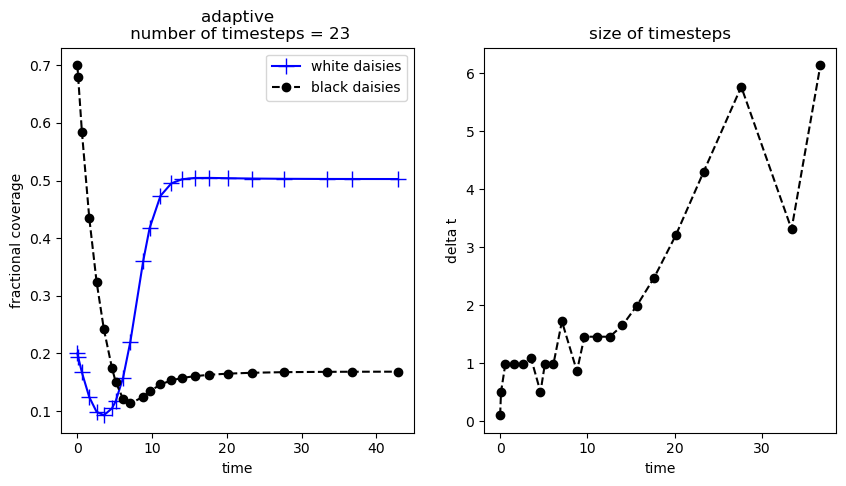

In [8]:
theSolver = Integ54('adapt.yaml')
a_timeVals, a_yVals, a_errorList = theSolver.timeloop5Err()

a_yvals = pd.DataFrame.from_records(a_yVals, columns=['white', 'black'])

thefig, (ax1,ax2) = plt.subplots(1, 2,figsize=(10,5))

points, = ax1.plot(a_timeVals, a_yvals['white'], '-b+', label='white daisies')
points.set_markersize(12)
theLine1, = ax1.plot(a_timeVals, a_yvals['black'], '--ko', label='black daisies')
ax1.set_title(f'adaptive\n number of timesteps = {len(a_timeVals)}')
ax1.set_xlabel('time')
#ax2 = theAx.twiny()
#ax2.plot(np.diff(a_timeVals))
ax1.set_ylabel('fractional coverage')
ax1.legend(loc='best')

ax2.plot(a_timeVals[:-1],np.diff(a_timeVals),'--ko')
ax2.set_ylabel('delta t')
ax2.set_xlabel('time')
ax2.set_title('size of timesteps')

In [33]:
a_yvals['white'].size

23

### part 2

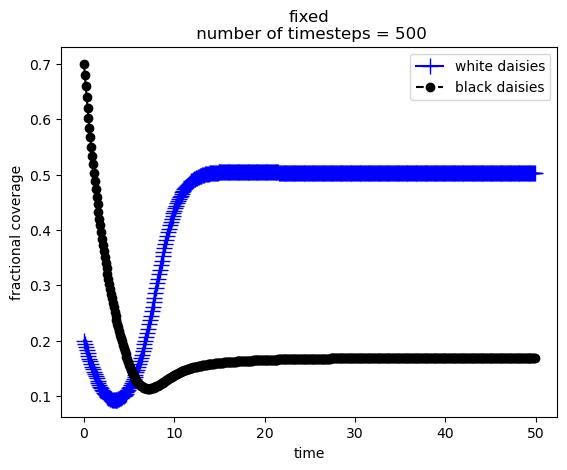

In [17]:
f_timeVals, f_yVals, f_errorList = theSolver.timeloop5fixed()

f_yvals = pd.DataFrame.from_records(f_yVals, columns=['white', 'black'])

thefig, theAx = plt.subplots(1, 1)

points, = theAx.plot(f_timeVals, f_yvals['white'], '-b+', label='white daisies')
points.set_markersize(12)
theLine1, = theAx.plot(f_timeVals, f_yvals['black'], '--ko', label='black daisies')
theAx.set_title(f'fixed\n number of timesteps = {len(f_timeVals)}')
theAx.set_xlabel('time')
theAx.set_ylabel('fractional coverage')
out = theAx.legend(loc='best')

# timeVals,yVals,errorList=theSolver.timeloop5fixed()
# whiteDaisies=[frac[0] for frac in yVals]

Text(0.5, 0.98, 'size of timesteps between adaptive and fixed')

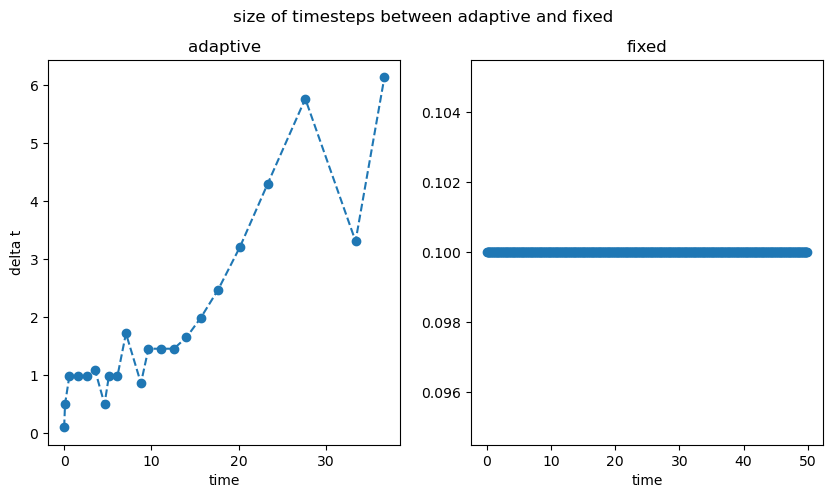

In [18]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
ax1.plot(a_timeVals[:-1],np.diff(a_timeVals),'--o')
ax1.set_title('adaptive')
ax1.set_ylabel('delta t')
ax1.set_xlabel('time')

ax2.plot(f_timeVals,[0.1 for i in range(len(f_timeVals))],'--o')
ax2.set_title('fixed')
ax2.set_xlabel('time')

fig.suptitle('size of timesteps between adaptive and fixed')


### Part 3

fixed is 500, adaptive is 23, fixed would have to be ~95% faster??? How do I show the size of the adaptive time steps, plot? 